In [ ]:

!pip install albumentations ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
import albumentations as A

In [ ]:
import gdown

url = "https://drive.google.com/uc?id=1MDkc6tsN907nljWaKOKOwYI6s7Jy4_oL"
output = "/content/my_data_sleep.v15i.yolov11.zip"
gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1MDkc6tsN907nljWaKOKOwYI6s7Jy4_oL
From (redirected): https://drive.google.com/uc?id=1MDkc6tsN907nljWaKOKOwYI6s7Jy4_oL&confirm=t&uuid=0e9b26d5-eb0e-43d4-bc08-849d0dd1c395
To: /content/my_data_sleep.v15i.yolov11.zip
100%|██████████| 90.6M/90.6M [00:00<00:00, 136MB/s]


'/content/my_data_sleep.v15i.yolov11.zip'

In [ ]:
!unzip -q /content/my_data_sleep.v15i.yolov11.zip -d /content/custom_data

replace /content/custom_data/README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/custom_data/README.roboflow.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/custom_data/data.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/custom_data/test/images/1117_jpg.rf.4ffb8a34941b14e5681d4da8237926fc.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/custom_data/test/images/1124_jpg.rf.843db61856633b8f61ff1b42fe4d1f6c.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

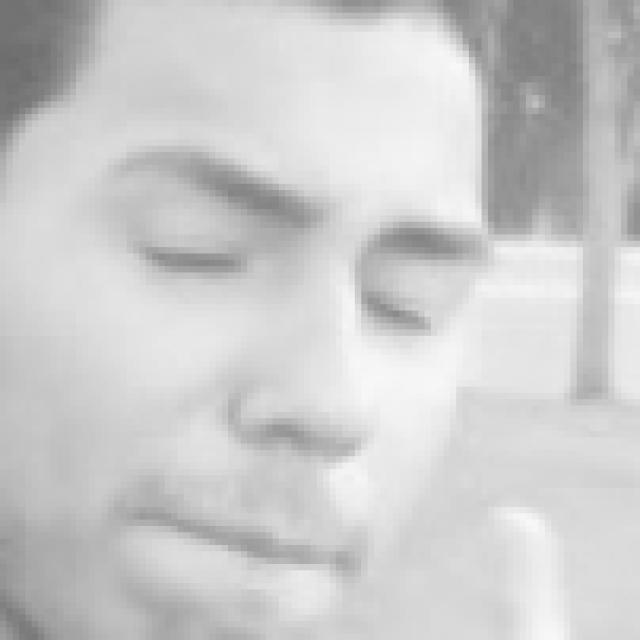

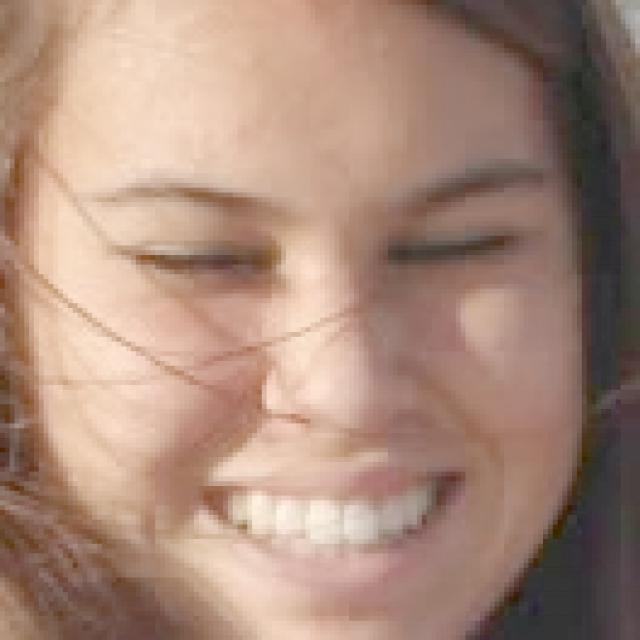

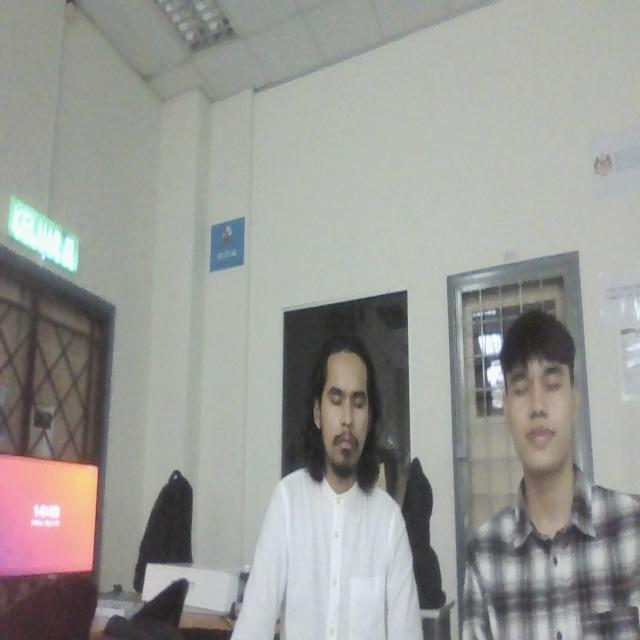

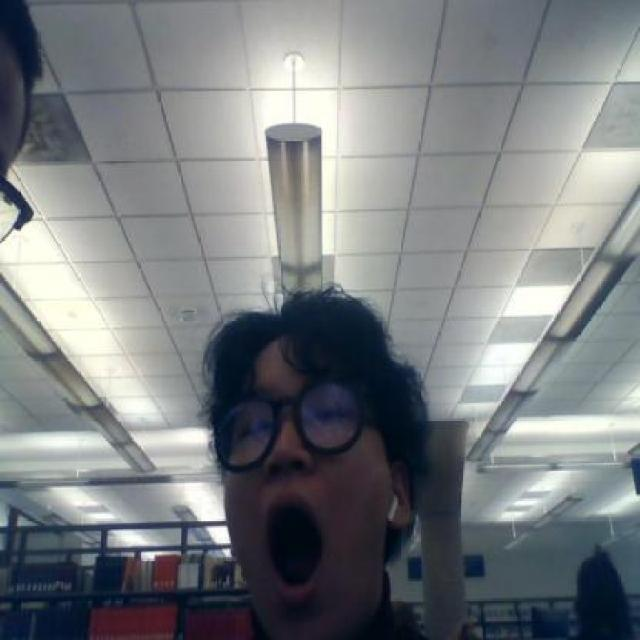

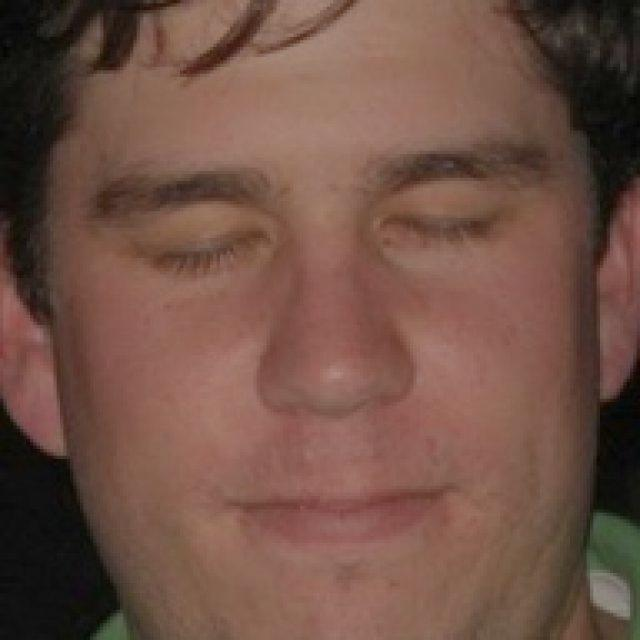

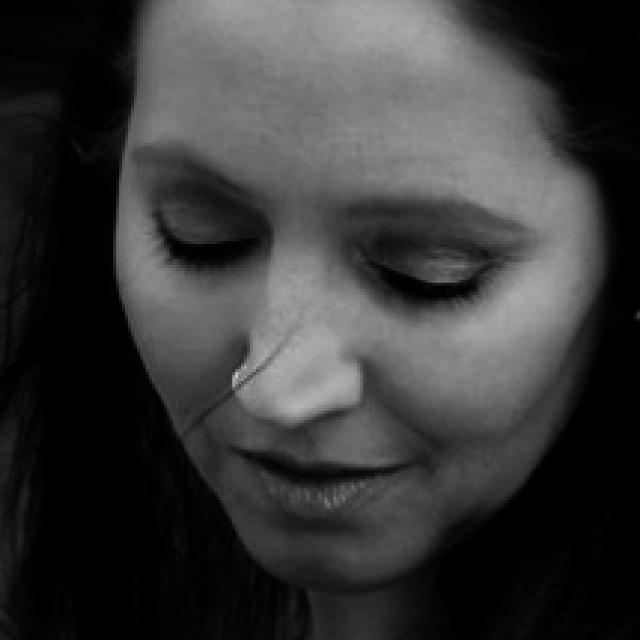

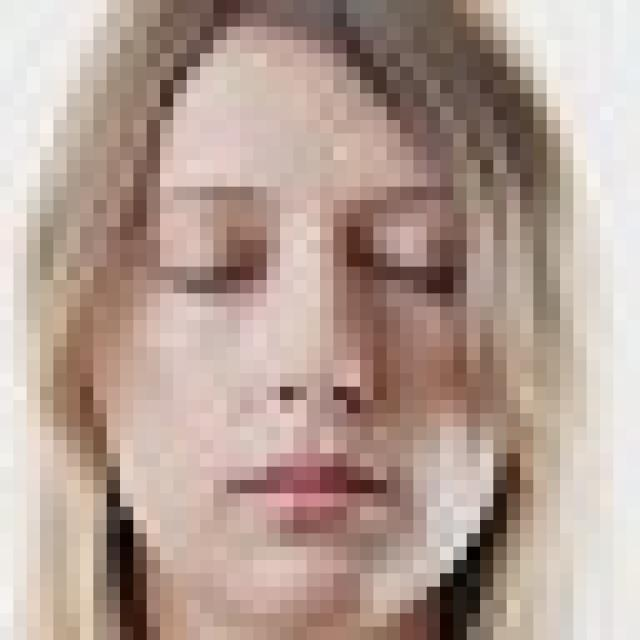

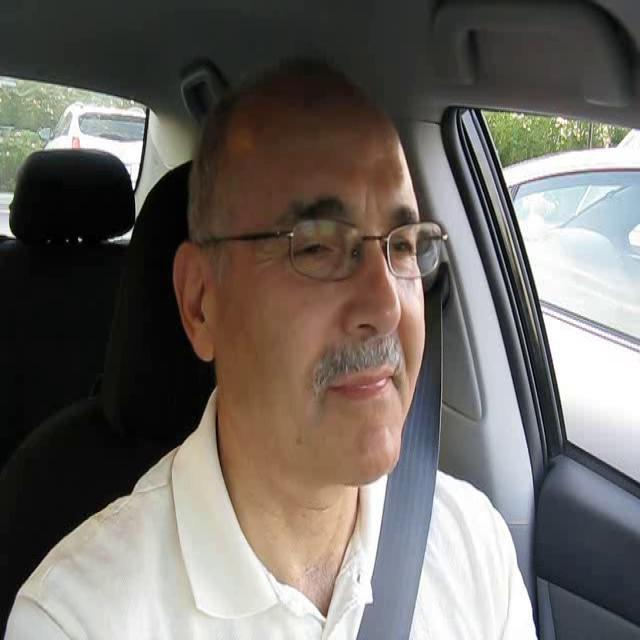

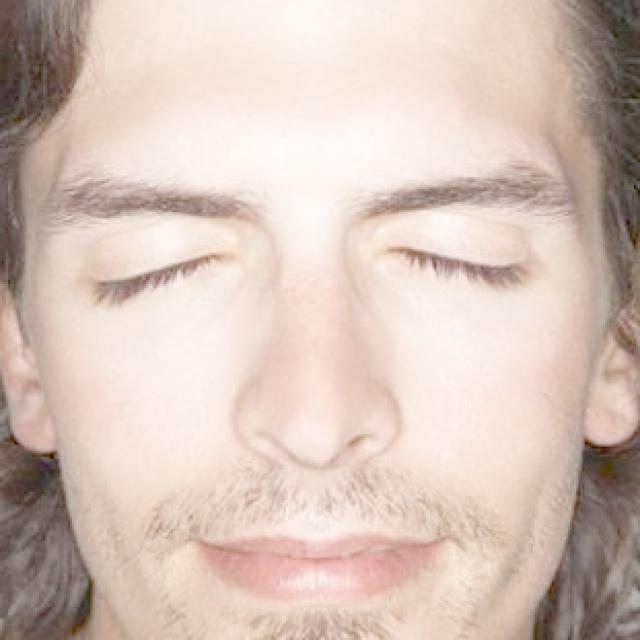

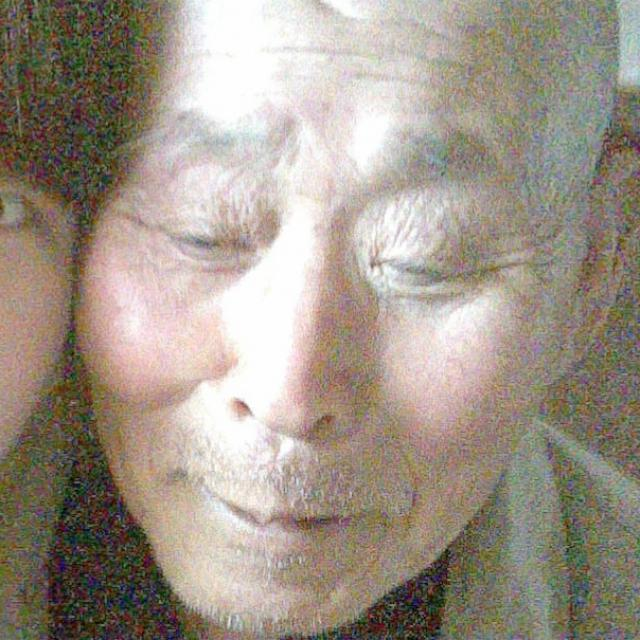

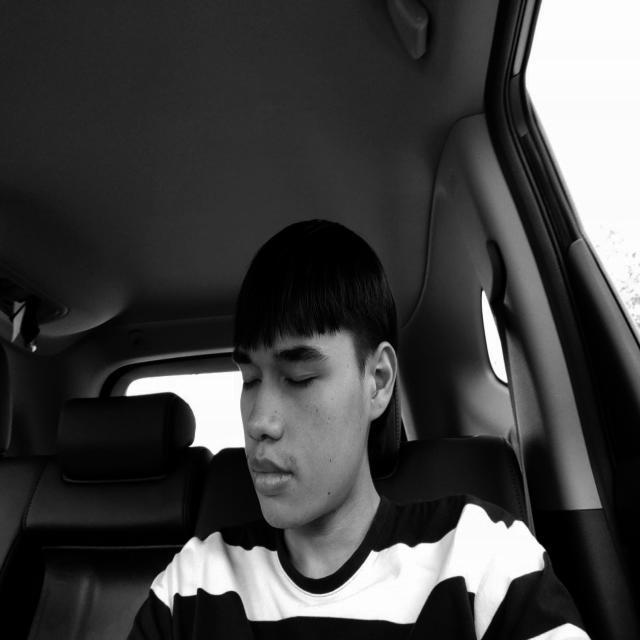

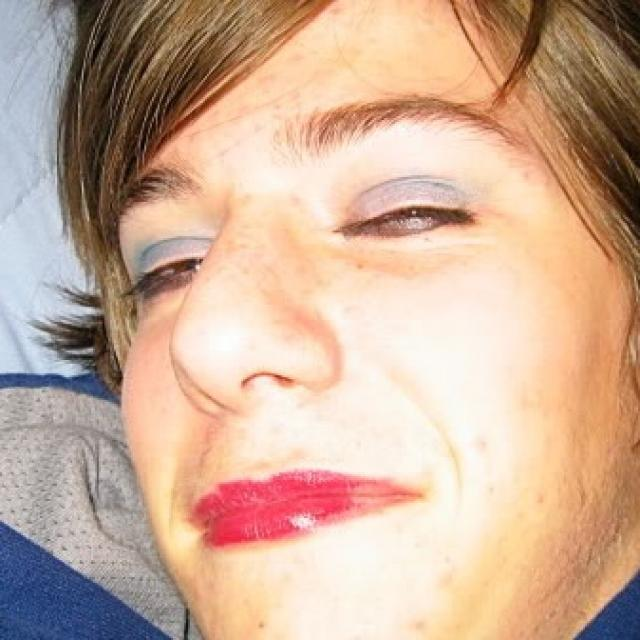

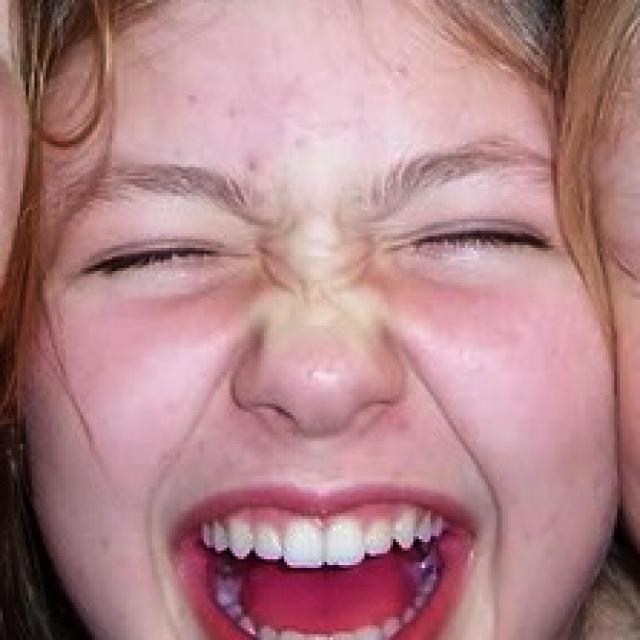

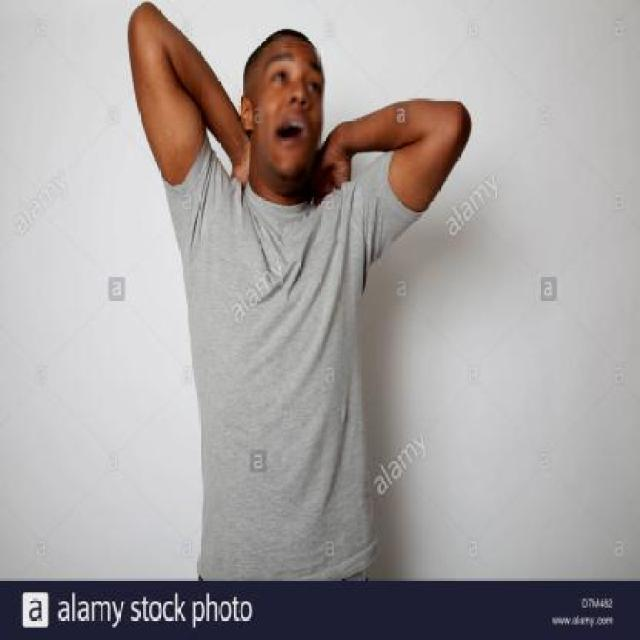

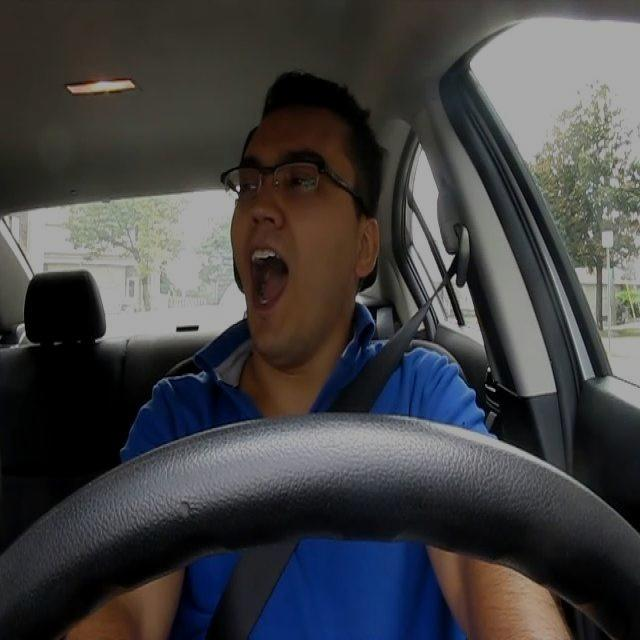

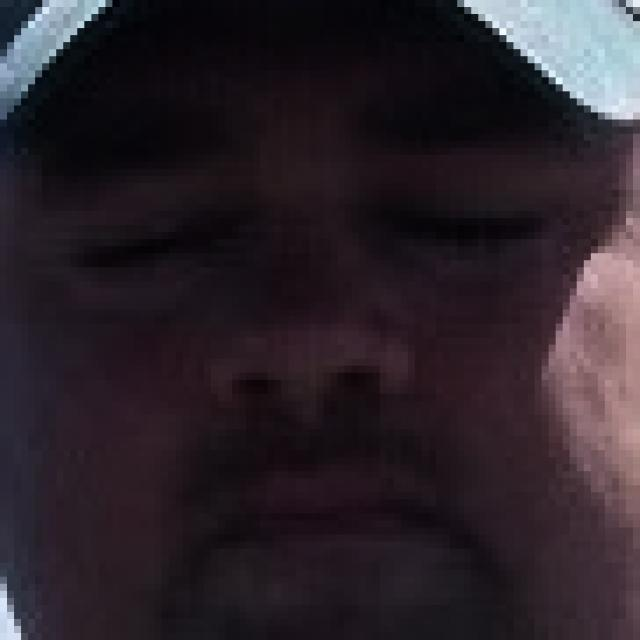

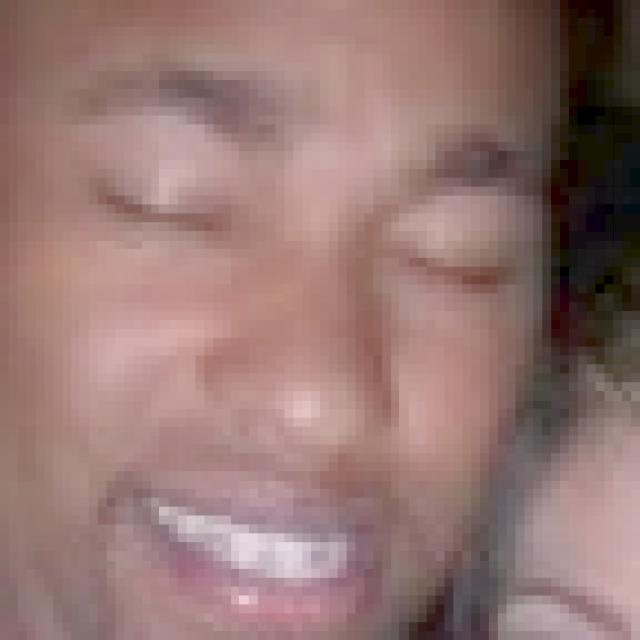

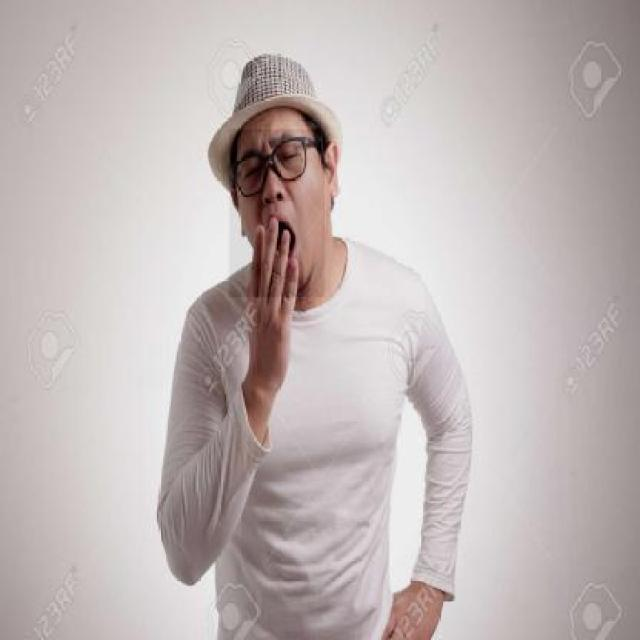

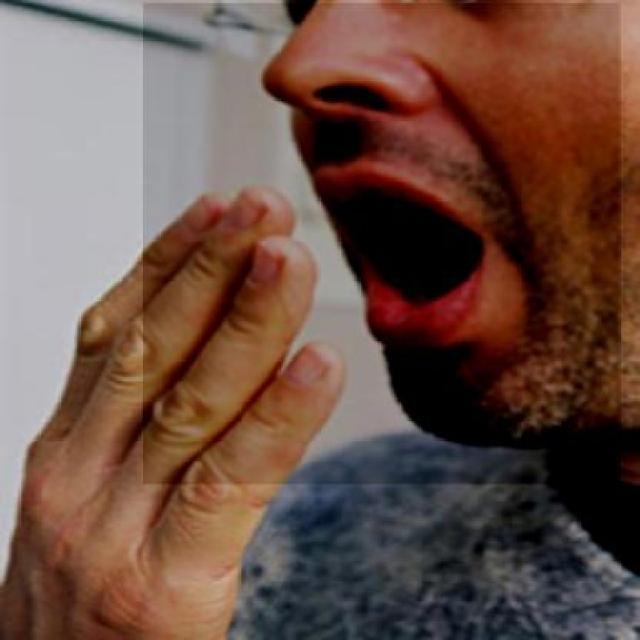

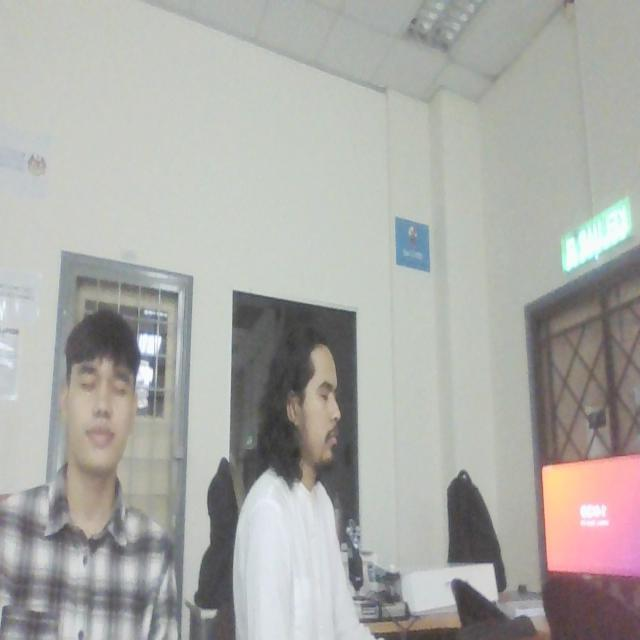

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob('/content/custom_data/train/images/*.jpg')[:20]:
    display(Image(filename=image_path, height=400))
    print('\n')


In [ ]:
import cv2
import os
import numpy as np
from albucore import clipped, float32_io, maybe_process_in_chunks, preserve_channel_dim, uint8_io
from typing import Tuple, Any, Dict
from tqdm import tqdm


In [ ]:
# menambah blur pada gambar (median blur)
def median_blur(img: np.ndarray, ksize: int) -> np.ndarray:

    blur_fn = maybe_process_in_chunks(cv2.medianBlur, ksize=ksize)
    return blur_fn(img)


In [ ]:
# manambah padding jika gambar bentuknya bukan persegi
def pad_adding(
    img: np.ndarray,
    target_size: Tuple[int, int] = (640, 640),
    pad_value: Tuple[float, ...] | float = 114,
    pad_mode: int = cv2.BORDER_CONSTANT,
    interpolation: int = cv2.INTER_LINEAR,
) -> np.ndarray:

    h, w = img.shape[:2]
    target_h, target_w = target_size

    scale = min(target_h / h, target_w / w)
    new_h, new_w = int(h * scale), int(w * scale)

    resized_img = cv2.resize(img, (new_w, new_h), interpolation=interpolation)

    pad_top = (target_h - new_h) // 2
    pad_bottom = target_h - new_h - pad_top
    pad_left = (target_w - new_w) // 2
    pad_right = target_w - new_w - pad_left

    padded_img = cv2.copyMakeBorder(
        resized_img,
        pad_top,
        pad_bottom,
        pad_left,
        pad_right,
        pad_mode,
        value=pad_value,
    )

    return padded_img

In [ ]:

def random_horizontal_flip(image: np.ndarray, instances: Any) -> dict:

    transform = A.HorizontalFlip(p=0.5)

    bboxes = np.array(instances['bboxes'])
    result = transform(image=image, bboxes=bboxes, keypoints=instances.get('keypoints', []))

    result["bboxes"] = result["bboxes"].tolist()
    return {"img": result["image"], "bboxes": result["bboxes"], "keypoints": result.get("keypoints", [])}

In [ ]:
def adjust_brightness_contrast(image: np.ndarray) -> np.ndarray:
    transform = A.RandomBrightnessContrast(
        brightness_limit=0.2,
        contrast_limit=0.2,
        p=0.7
    )
    return transform(image=image)["image"]

In [ ]:
train_images_set = "custom_data/train/images"
train_labels_set = "custom_data/train/labels"

preprocessed_images = "custom_data/train_augmented/images"
preprocessed_labels = "custom_data/train_augmented/labels"

# os.makedirs(preprocessed_images, exist_ok=True)
# os.makedirs(preprocessed_labels, exist_ok=True)



In [ ]:
def process_dataset(
    train_images_set: str,
    train_labels_set: str,
    preprocessed_images: str,
    preprocessed_labels: str,
    target_size: Tuple[int, int] = (640, 640)
):
    os.makedirs(preprocessed_images, exist_ok=True)
    os.makedirs(preprocessed_labels, exist_ok=True)

    image_files = [f for f in os.listdir(train_images_set)
                  if f.lower().endswith(('.jpg'))]

    for filename in tqdm(image_files, desc="Processing images"):

        img_path = os.path.join(train_images_set, filename)
        image = cv2.imread(img_path)


        label_path = os.path.join(train_labels_set, os.path.splitext(filename)[0] + '.txt')
        instances = load_yolo_labels(label_path, image.shape)

        if image is not None and instances is not None:

            if np.random.rand() < 0.5:
                image = median_blur(image, ksize=5)


            image = pad_adding(image, target_size=target_size)

            result = random_horizontal_flip(image, instances)
            image = result["img"]
            instances = {
                "bboxes": result["bboxes"],
                "keypoints": result["keypoints"]
            }

            image = adjust_brightness_contrast(image)

            # simpan gambar hasil augmentasi
            output_img_path = os.path.join(preprocessed_images, filename)
            cv2.imwrite(output_img_path, image)

            # simpan label yang sudah diupdate
            save_yolo_labels(instances, os.path.join(preprocessed_labels, os.path.splitext(filename)[0] + '.txt'), target_size)

        else :
          print('error ')



In [ ]:
def load_yolo_labels(label_path: str, img_shape: Tuple[int, int]) -> Dict[str, Any]:

    instances = {"bboxes": [], "keypoints": []}
    if not os.path.exists(label_path):
        return instances

    with open(label_path, 'r') as f:

        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id, x_center, y_center, width, height = map(float, parts[:5])
                # Convert YOLO to Pascal VOC -> ini biar perhitungan perubahan labelnya lebih presisi karena pake pixel
                img_h, img_w = img_shape[:2]

                x_min = (x_center - width/2) * img_w
                y_min = (y_center - height/2) * img_h
                x_max = (x_center + width/2) * img_w
                y_max = (y_center + height/2) * img_h
                instances["bboxes"].append([x_min, y_min, x_max, y_max, class_id])

    return instances





In [ ]:
def save_yolo_labels(instances: Dict[str, Any], output_path: str, img_size: Tuple[int, int]):

    with open(output_path, 'w') as f:

        for bbox in instances.get("bboxes", []):

            if len(bbox) >= 5:  # x_min, y_min, x_max, y_max, class_id
                x_min, y_min, x_max, y_max, class_id = bbox[:5]
                img_w, img_h = img_size

                # Convert format Pascal VOC ke YOLO

                x_center = ((x_min + x_max) / 2) / img_w
                y_center = ((y_min + y_max) / 2) / img_h
                width = (x_max - x_min) / img_w
                height = (y_max - y_min) / img_h

                f.write(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")


In [ ]:
process_dataset(
    train_images_set,
    train_labels_set,
    preprocessed_images,
    preprocessed_labels,
    (640, 640)
)

Processing images: 100%|██████████| 2103/2103 [00:15<00:00, 131.84it/s]


In [ ]:
!yolo detect train data=/content/custom_data/data.yaml model=yolo11s.pt epochs=25 imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 18.4M/18.4M [00:00<00:00, 448MB/s]
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/custom_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, i

In [ ]:
#!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True
!yolo detect predict model=runs/detect/train/weights/best.pt source=custom_data/valid/images save=True

Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs

image 1/335 /content/custom_data/valid/images/1119_jpg.rf.91d46280ad89b15c0ee54f9be1269f6e.jpg: 640x640 1 sleepy, 15.6ms
image 2/335 /content/custom_data/valid/images/111_jpg.rf.38c57c78456b88fb930938d7479369e0.jpg: 640x640 1 sleepy, 15.6ms
image 3/335 /content/custom_data/valid/images/1120_jpg.rf.621f4181e1de6e2aa1ace3b48272e757.jpg: 640x640 1 sleepy, 15.5ms
image 4/335 /content/custom_data/valid/images/1135_jpg.rf.3707cd5d7ffd66b4132a1820851fccc2.jpg: 640x640 1 sleepy, 15.5ms
image 5/335 /content/custom_data/valid/images/1162_jpg.rf.929455b9233c8038b7d9e7216eb639e3.jpg: 640x640 1 sleepy, 15.6ms
image 6/335 /content/custom_data/valid/images/1326_jpg.rf.6047cfd494998526be39f78e59c64d6d.jpg: 640x640 1 active, 16.2ms
image 7/335 /content/custom_data/valid/images/1337_jpg.rf.f849c4ab313146251fbc9be021a9fab5.jpg: 640x640 1 a

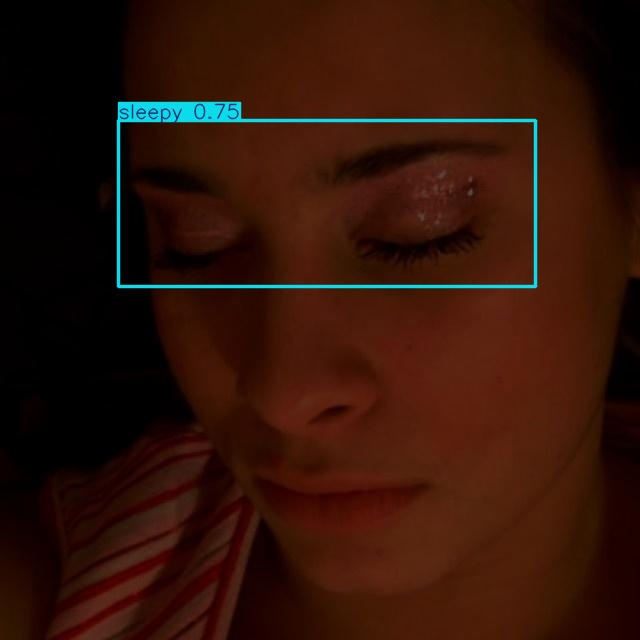

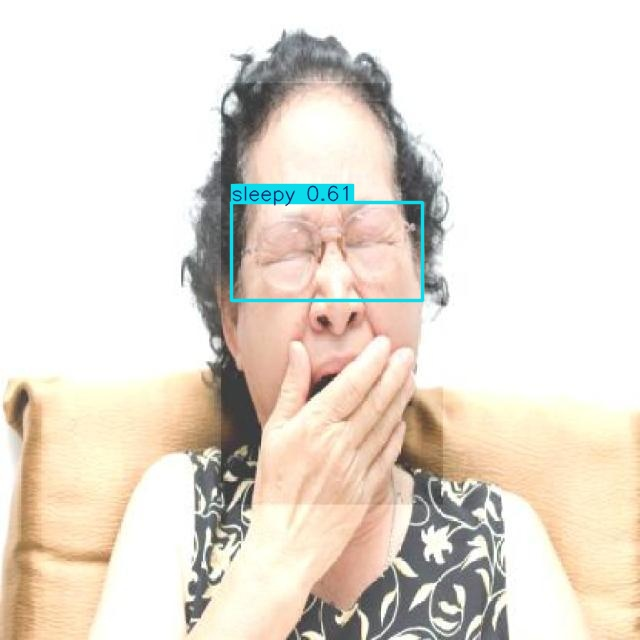

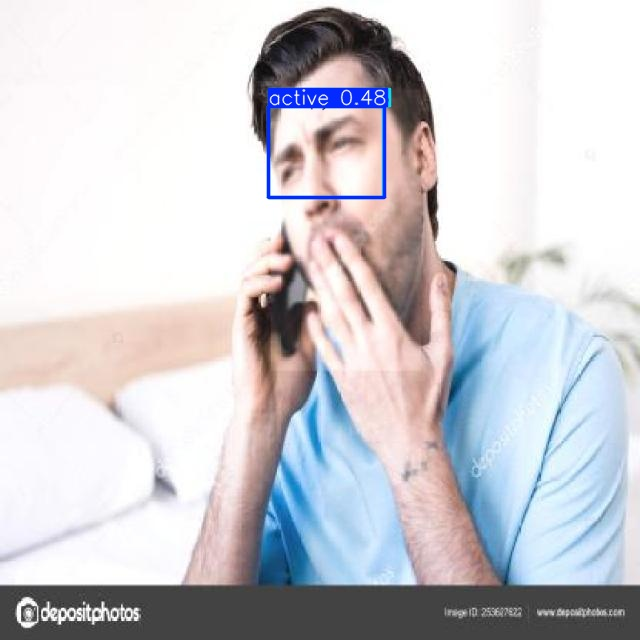

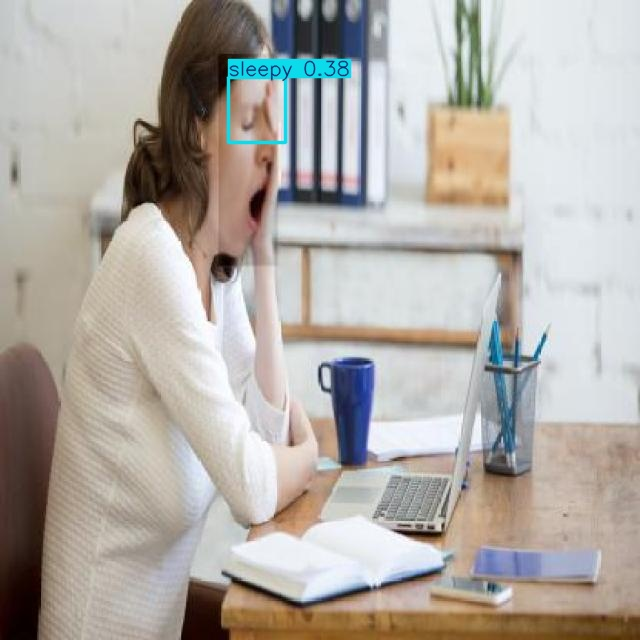

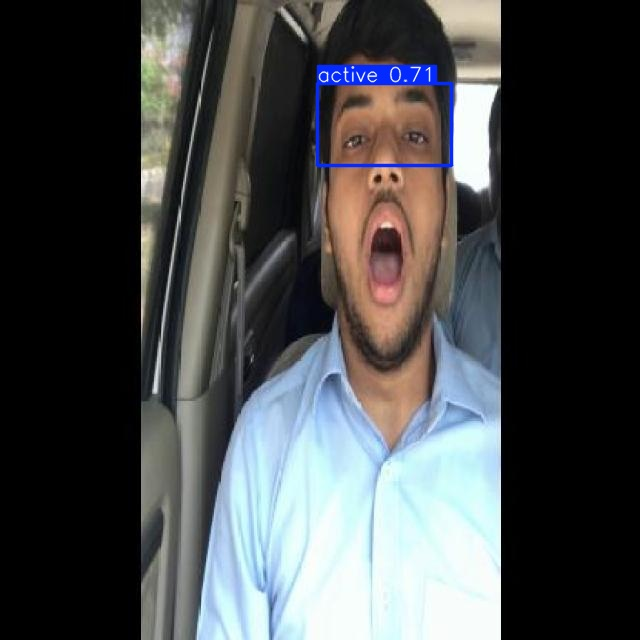

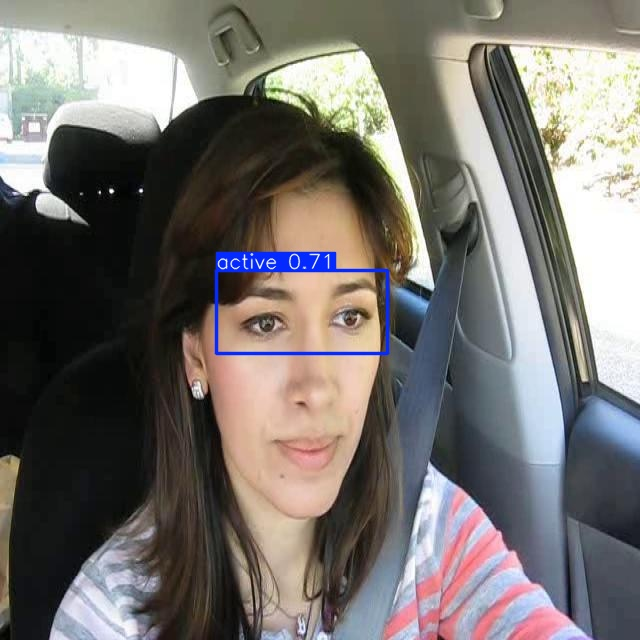

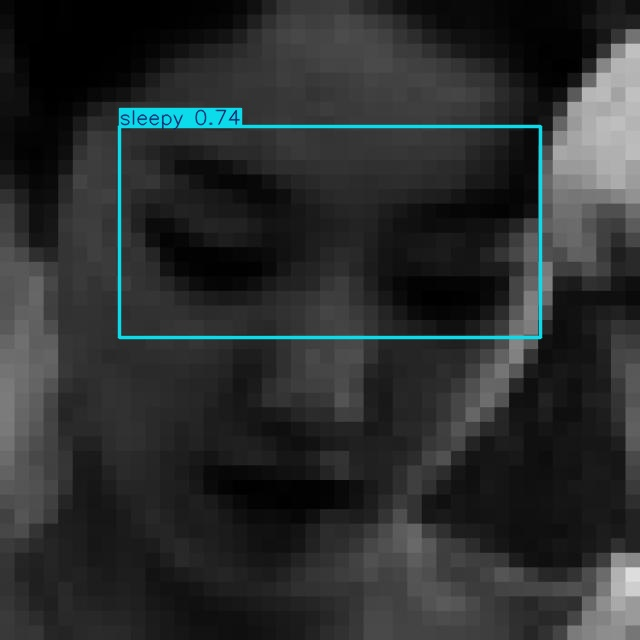

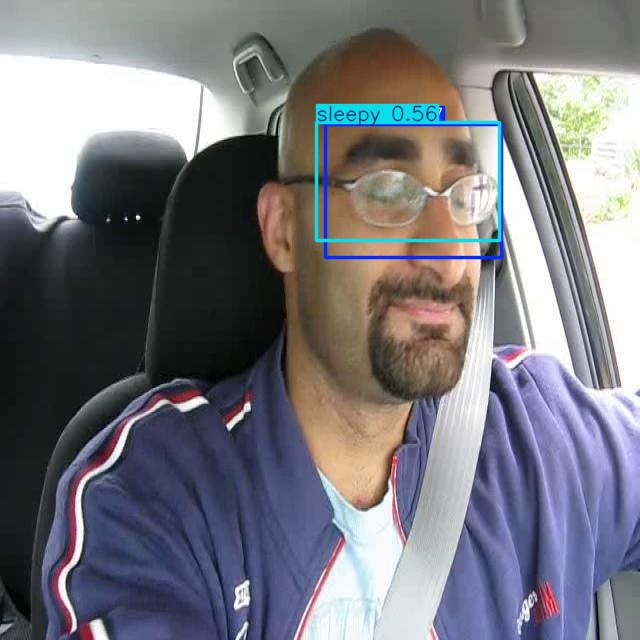

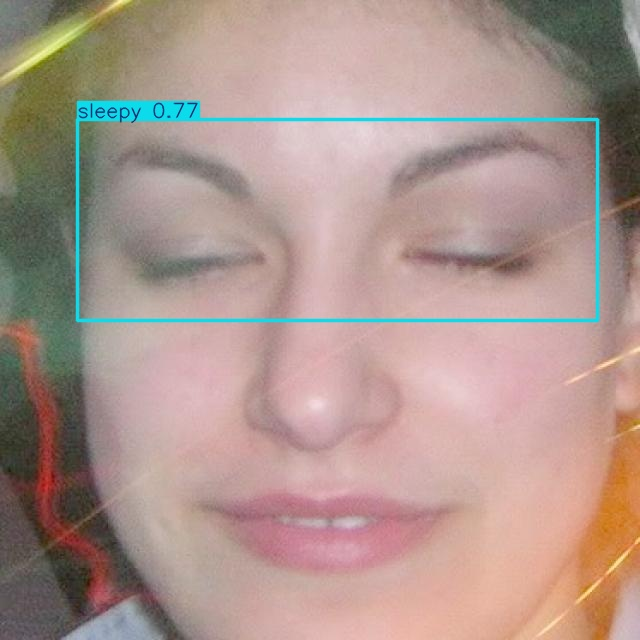

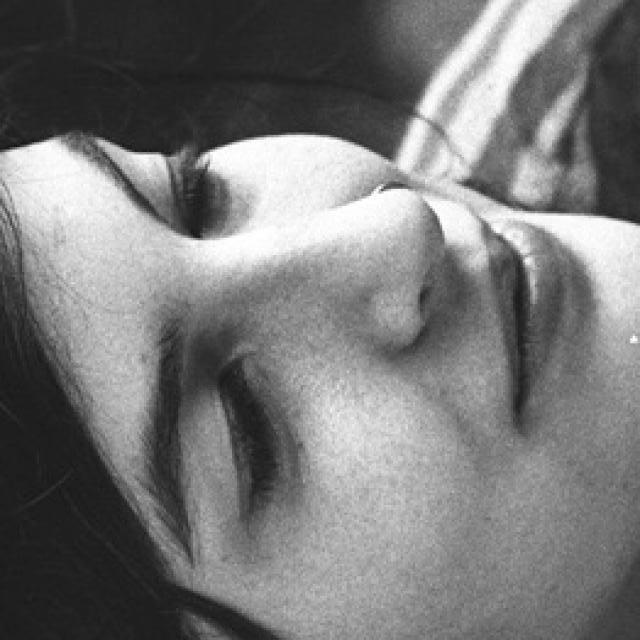

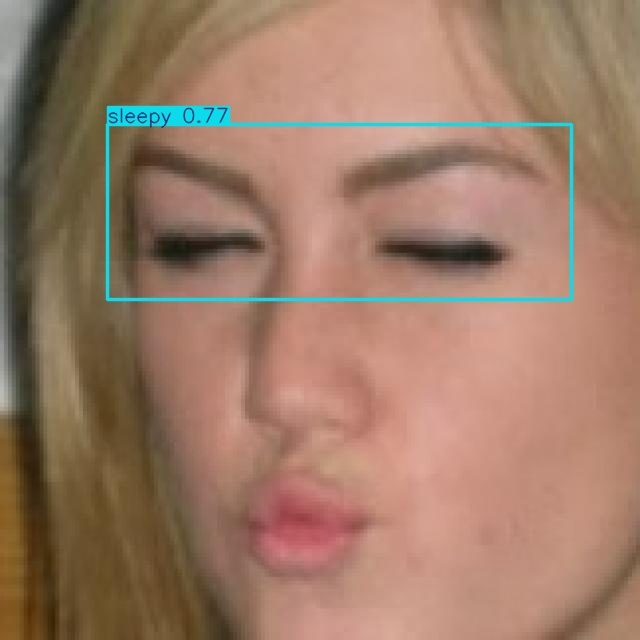

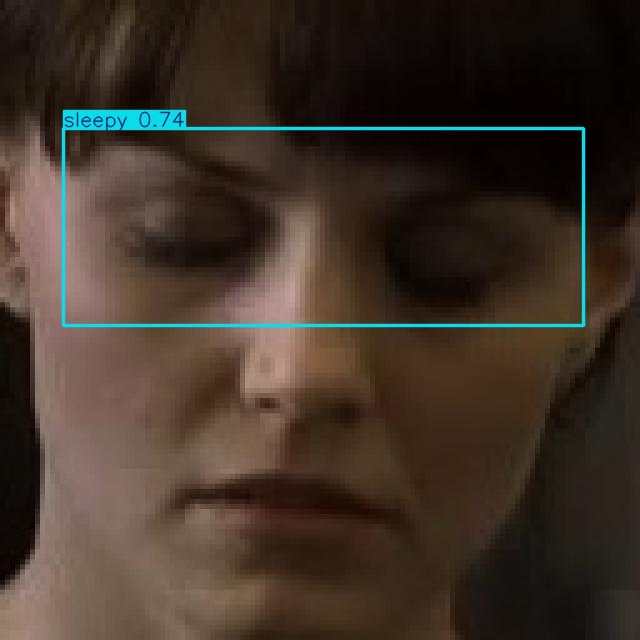

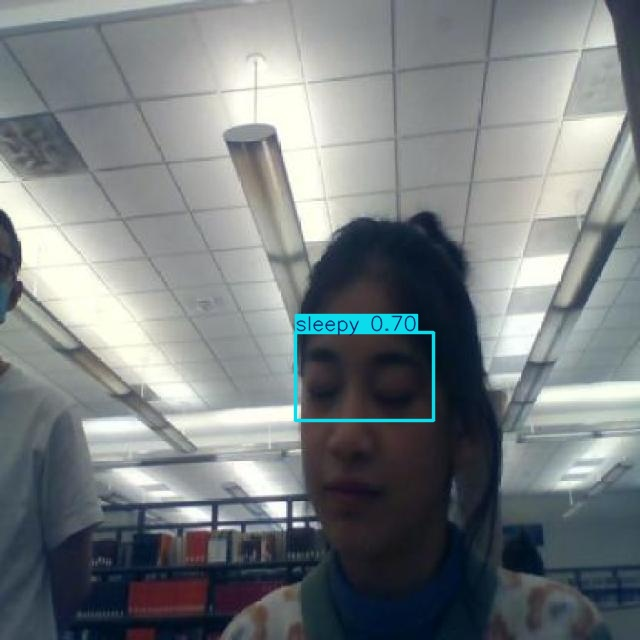

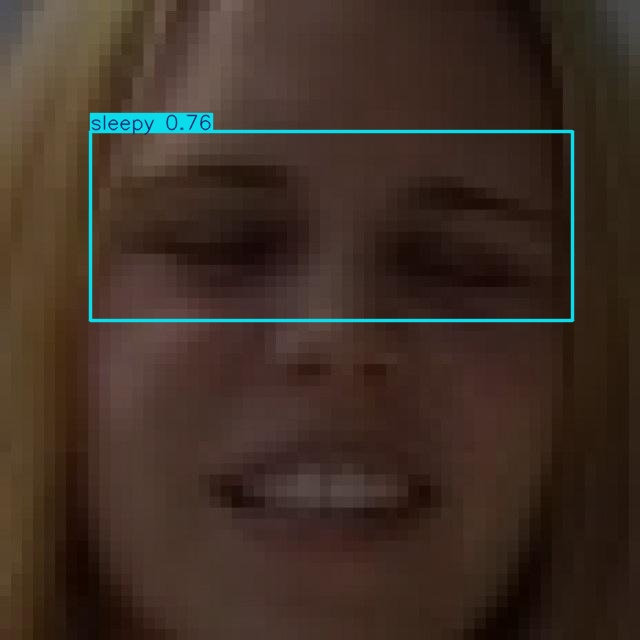

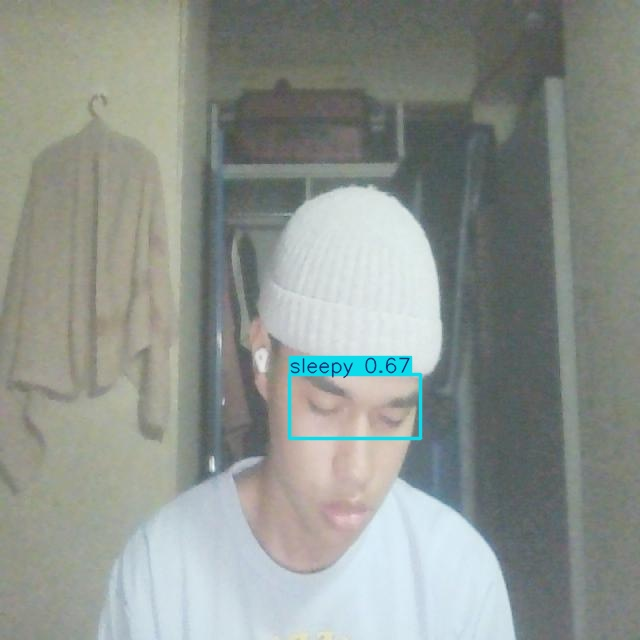

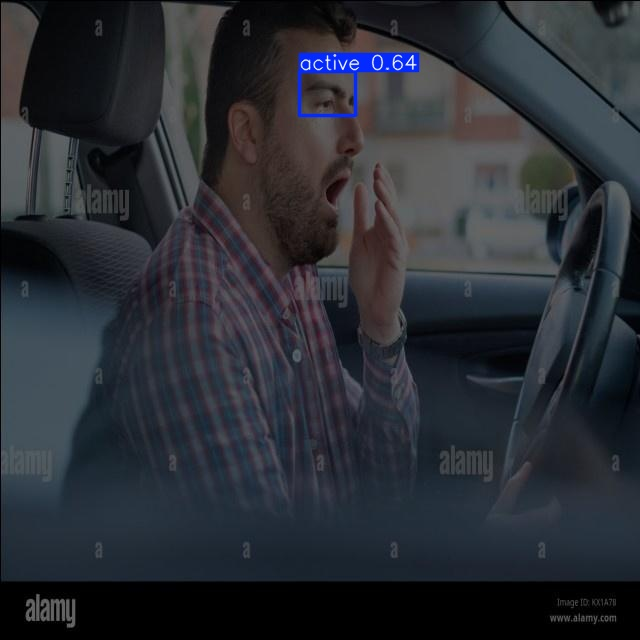

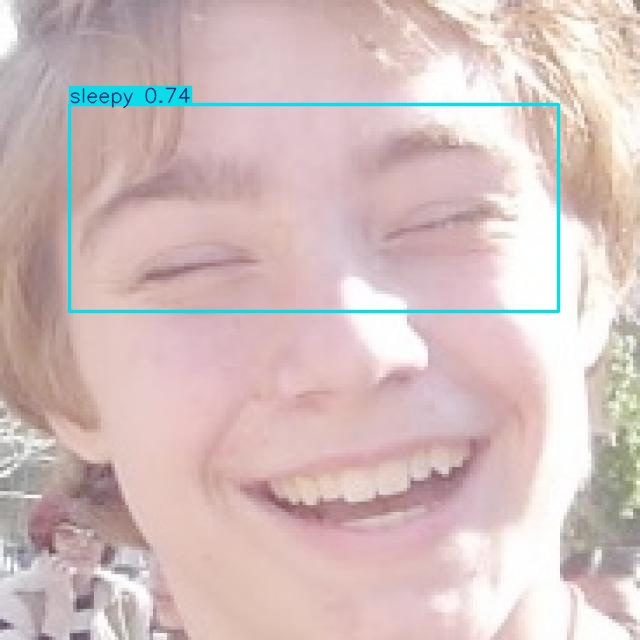

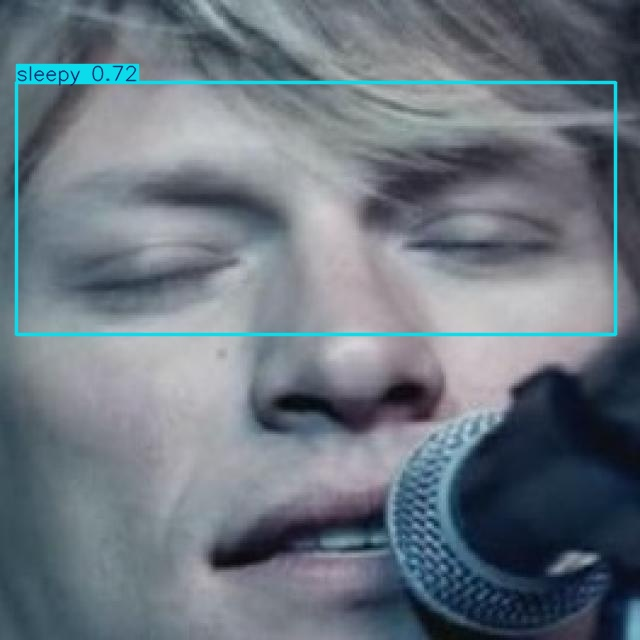

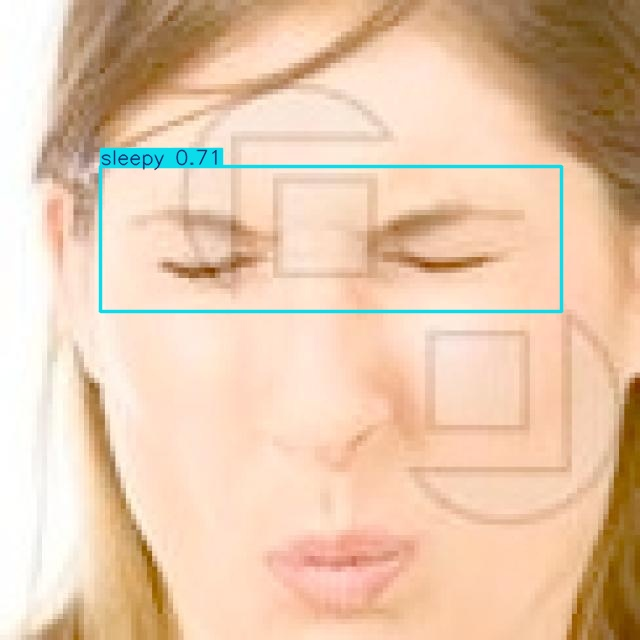

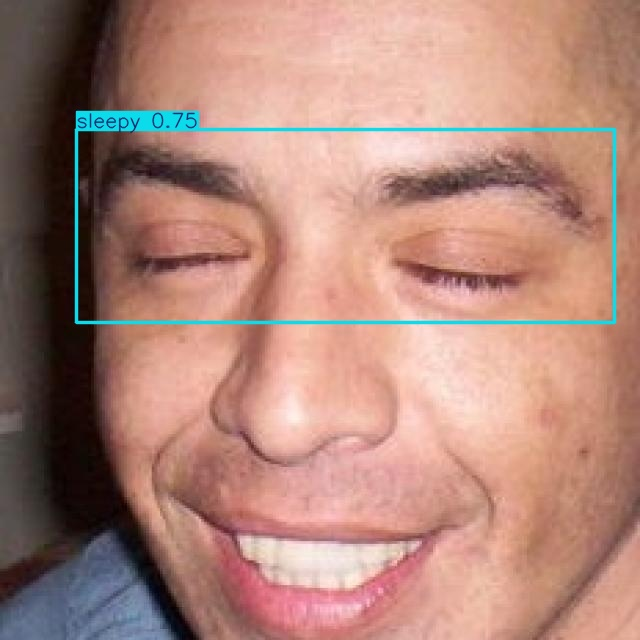

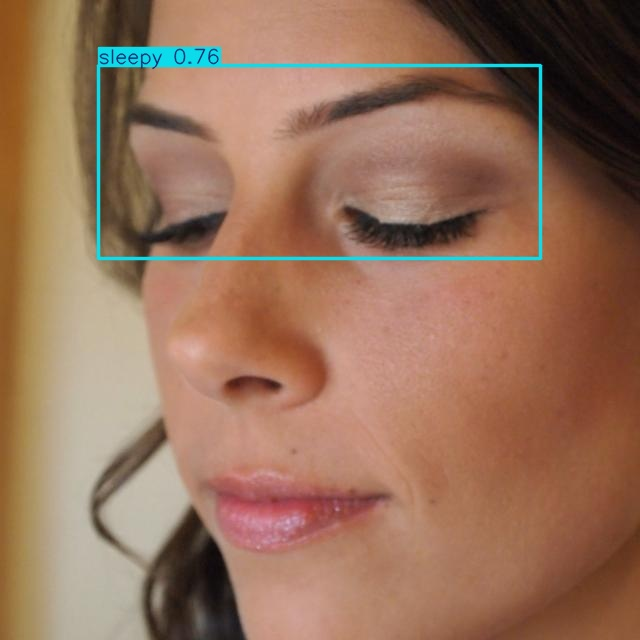

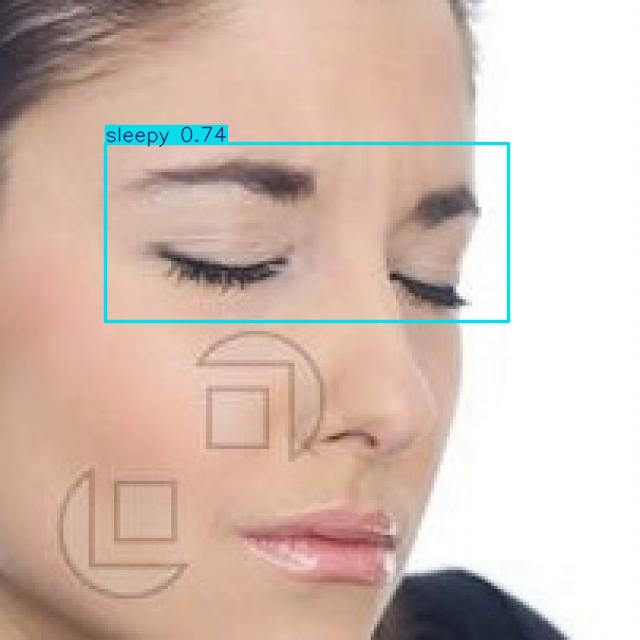

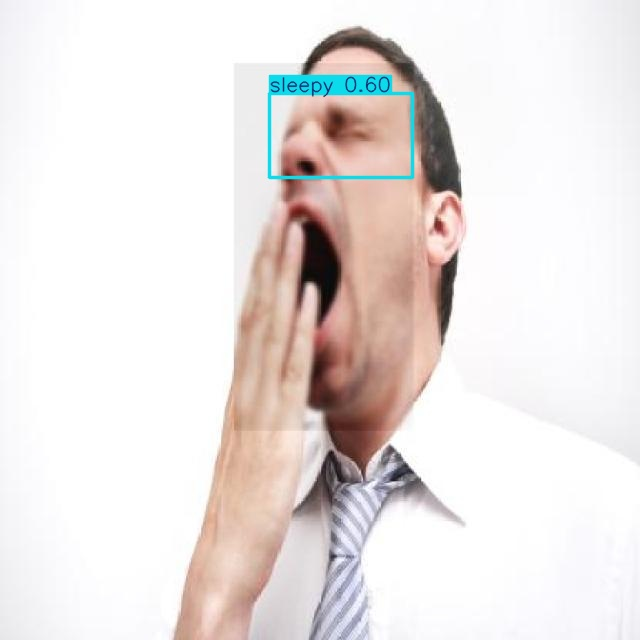

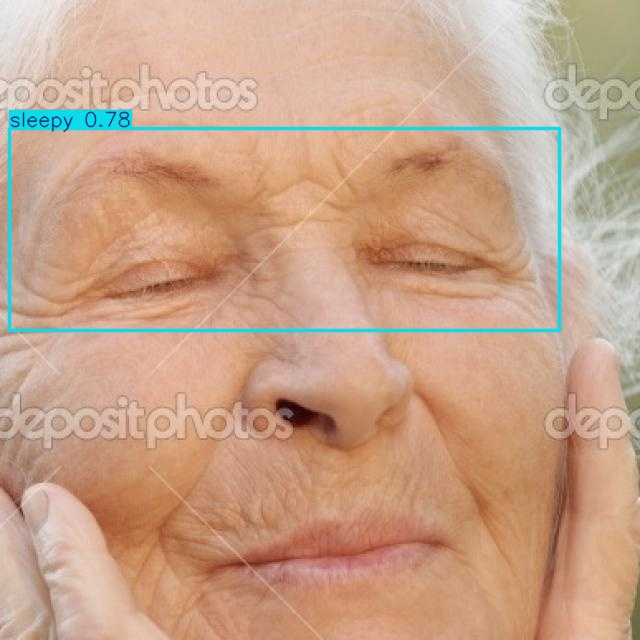

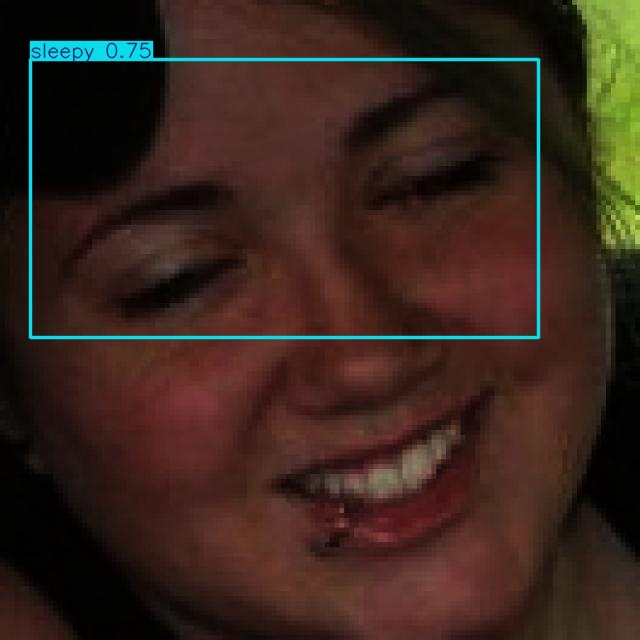

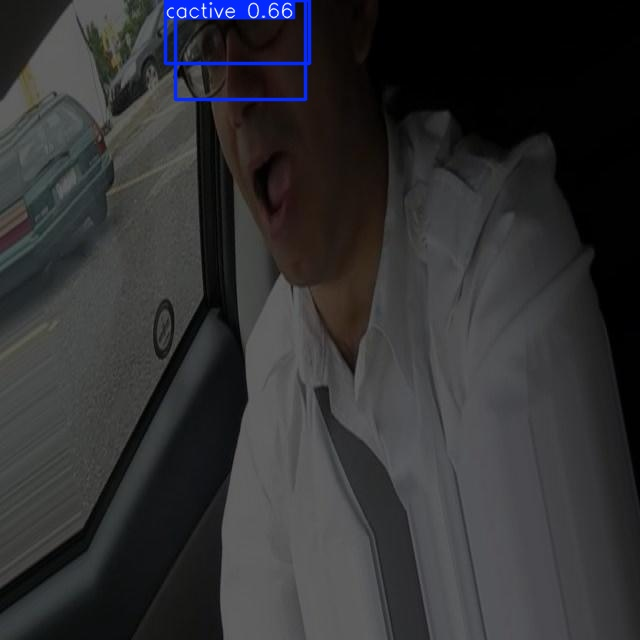

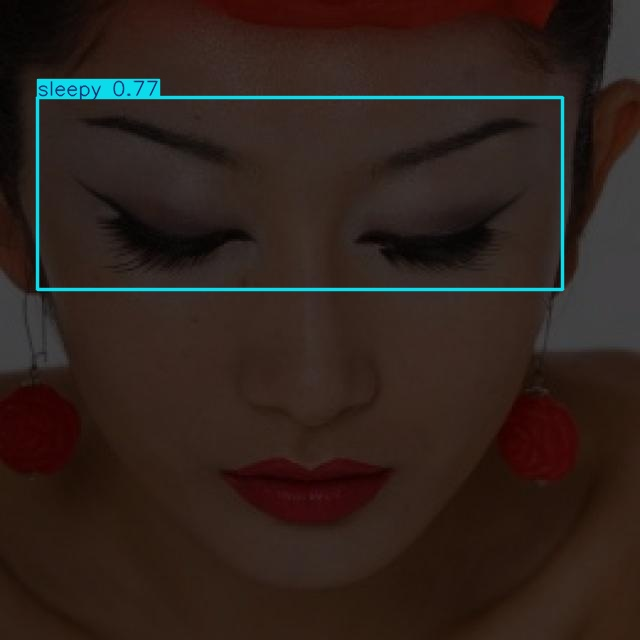

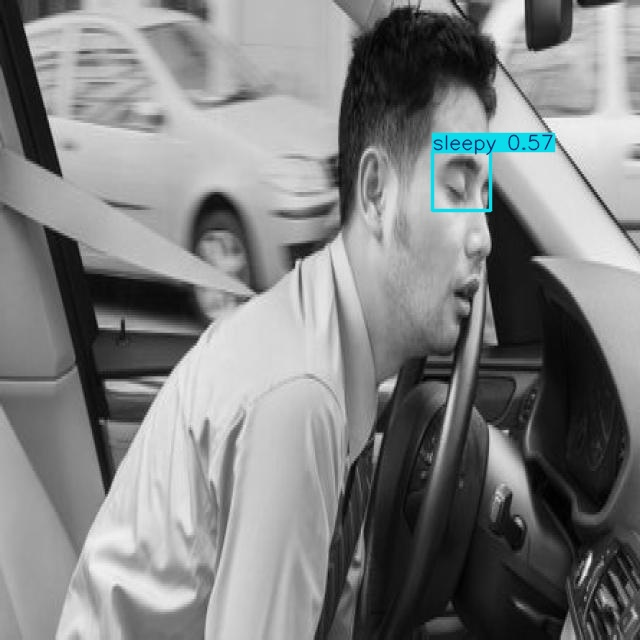

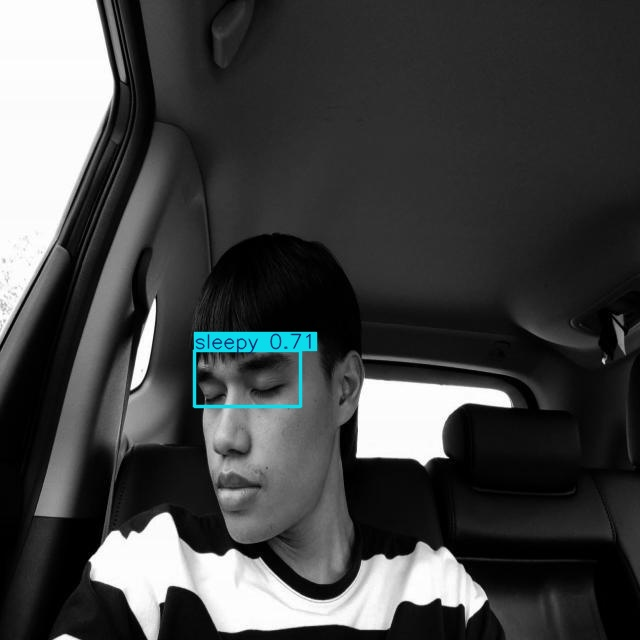

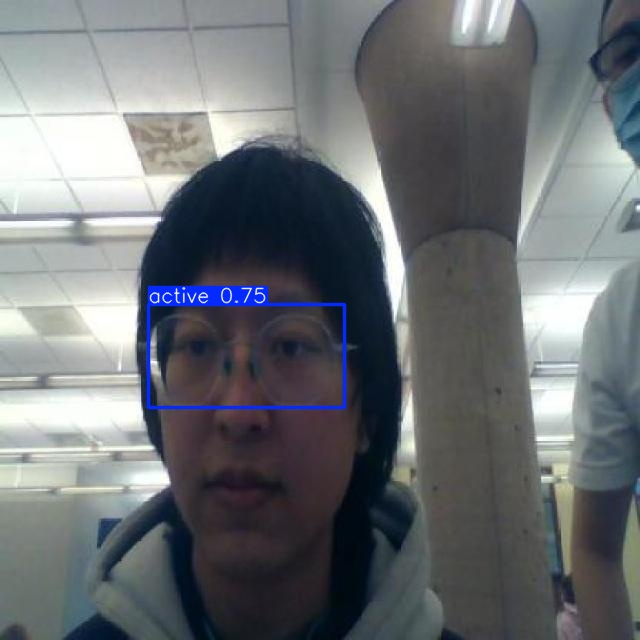

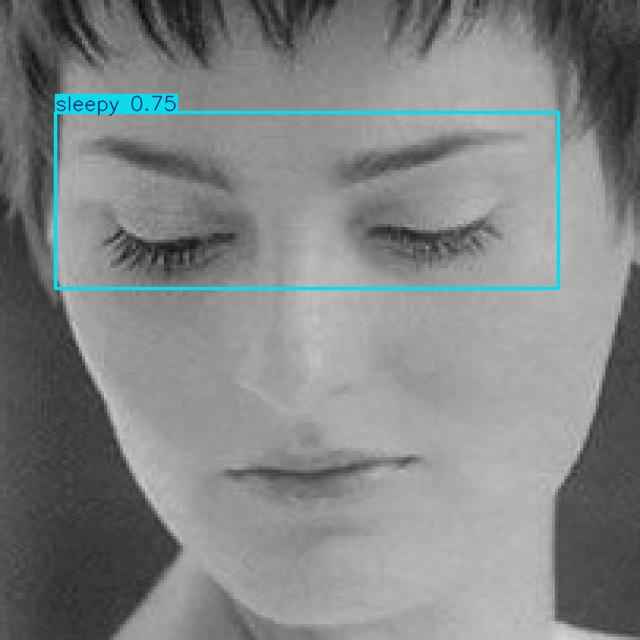

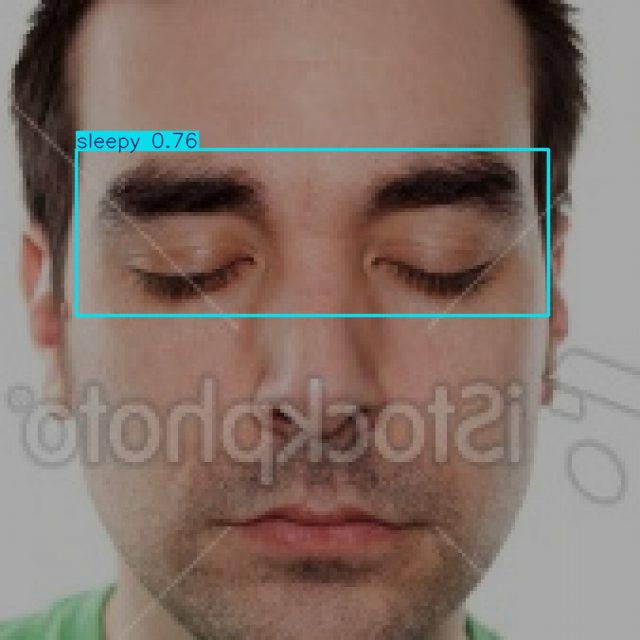

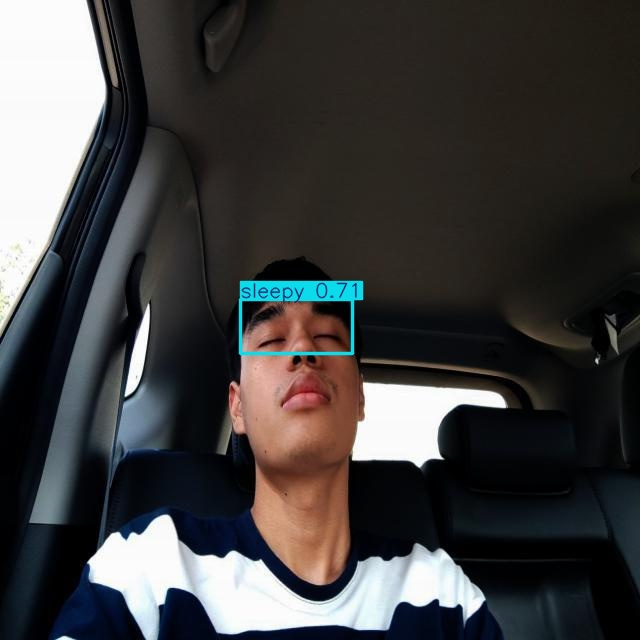

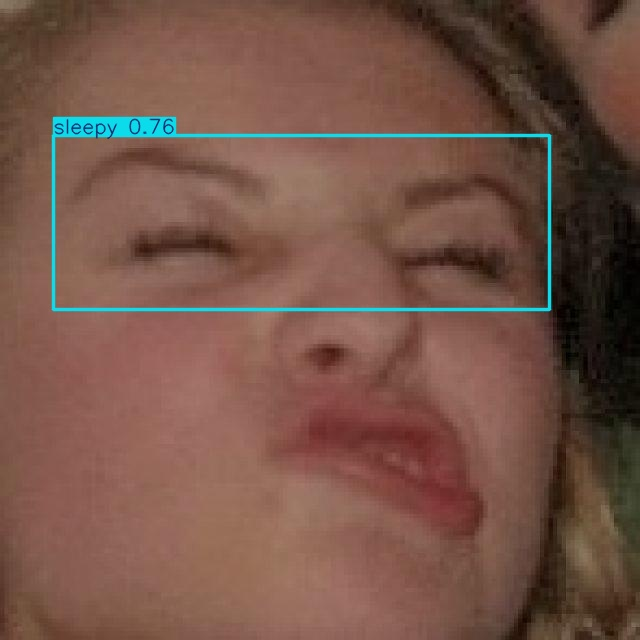

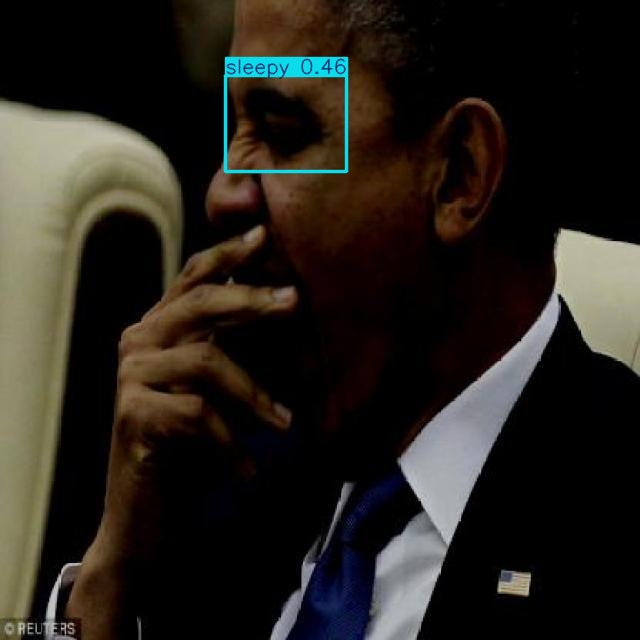

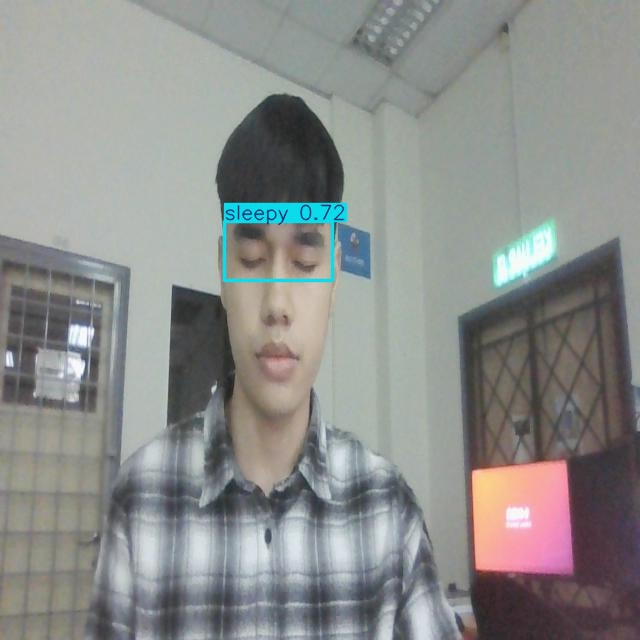

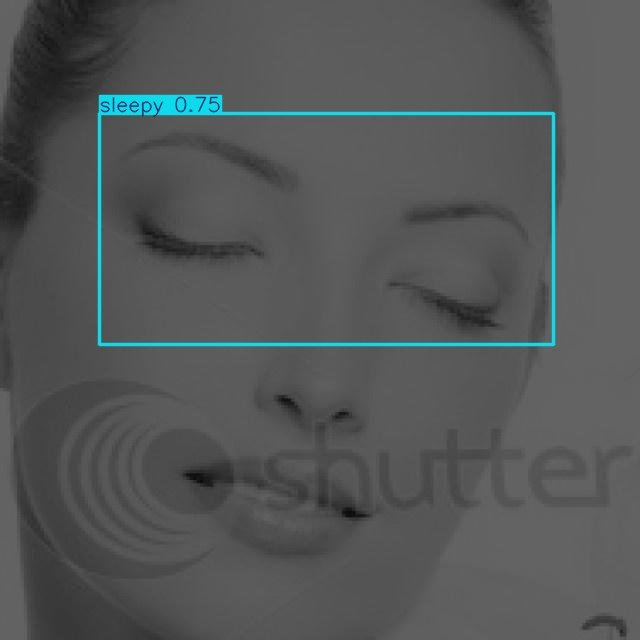

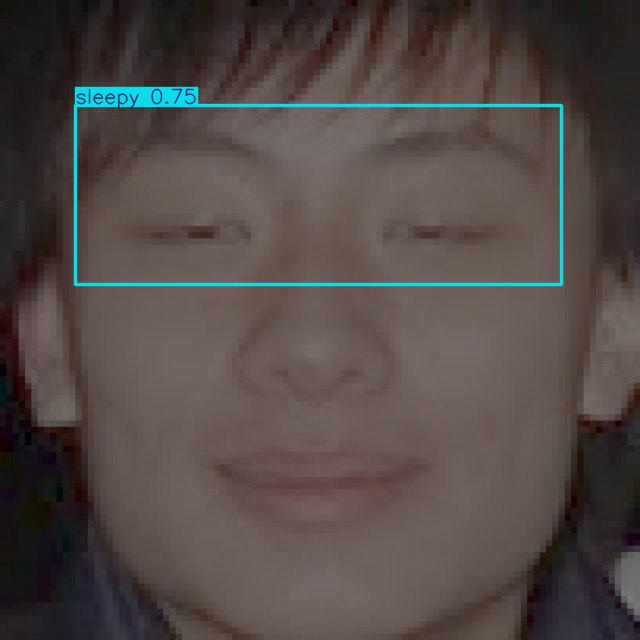

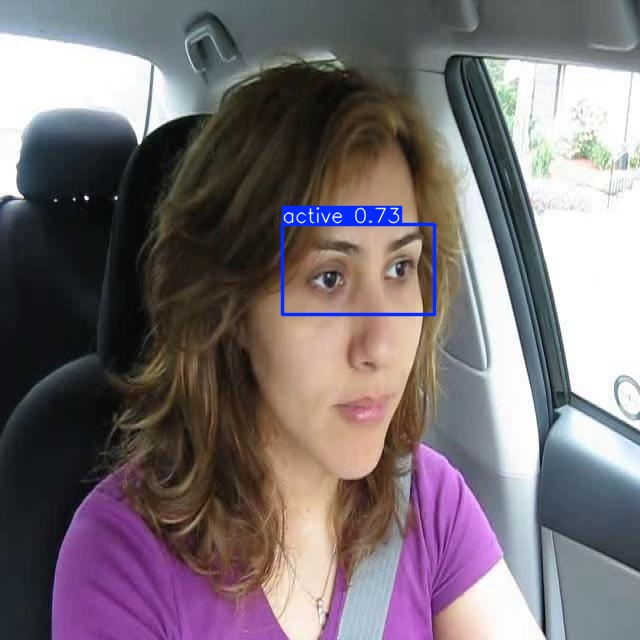

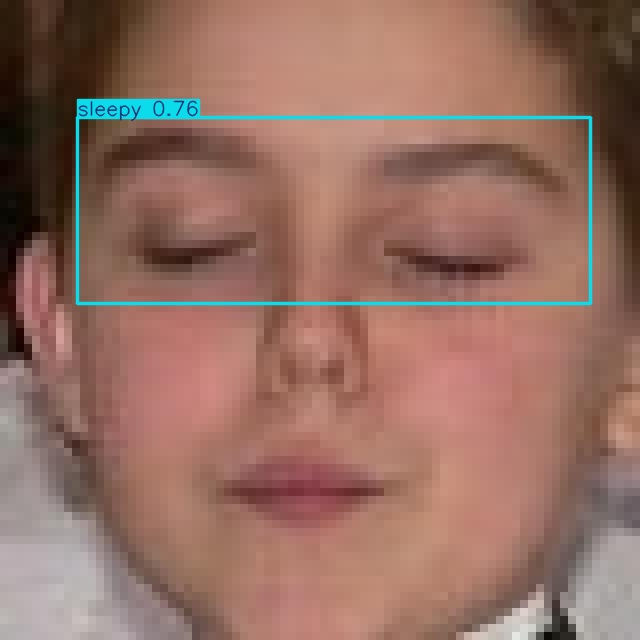

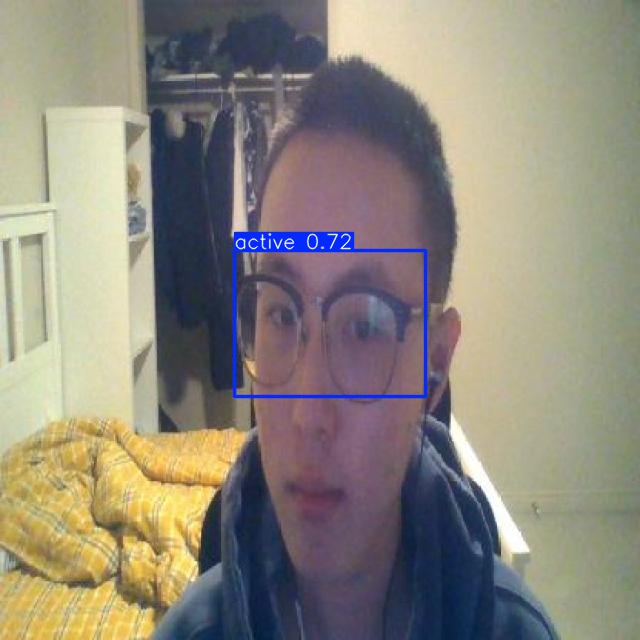

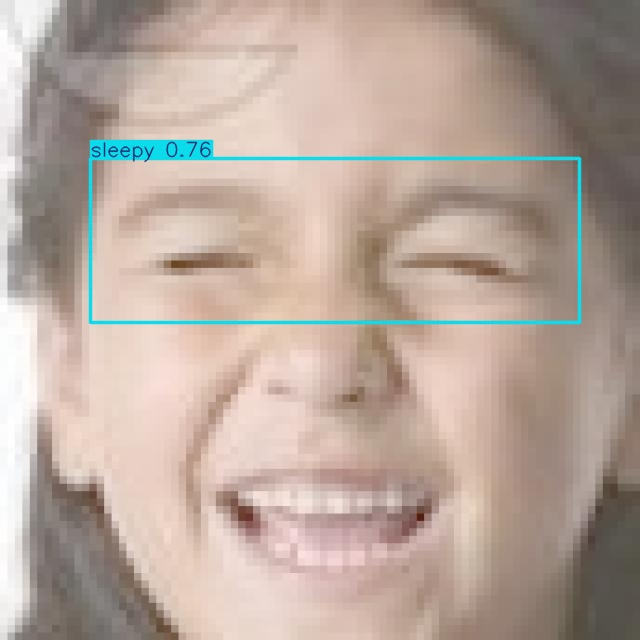

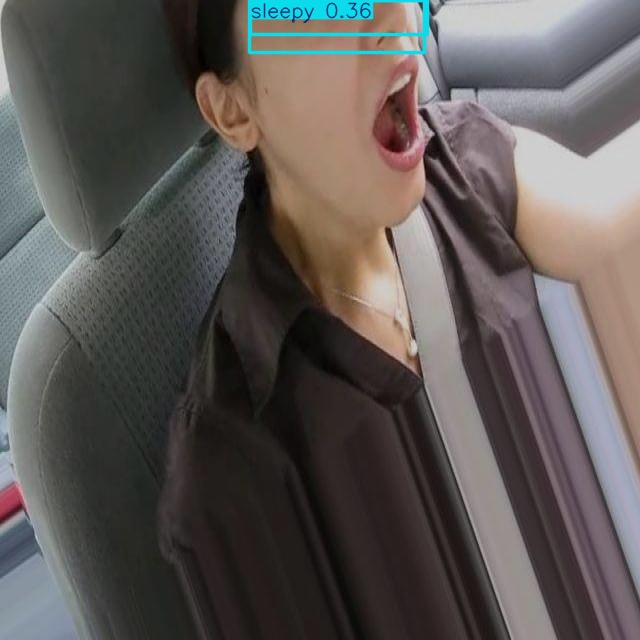

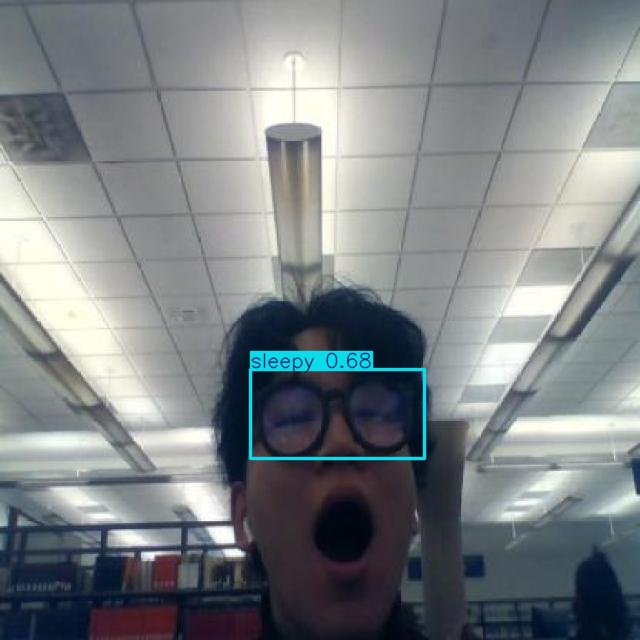

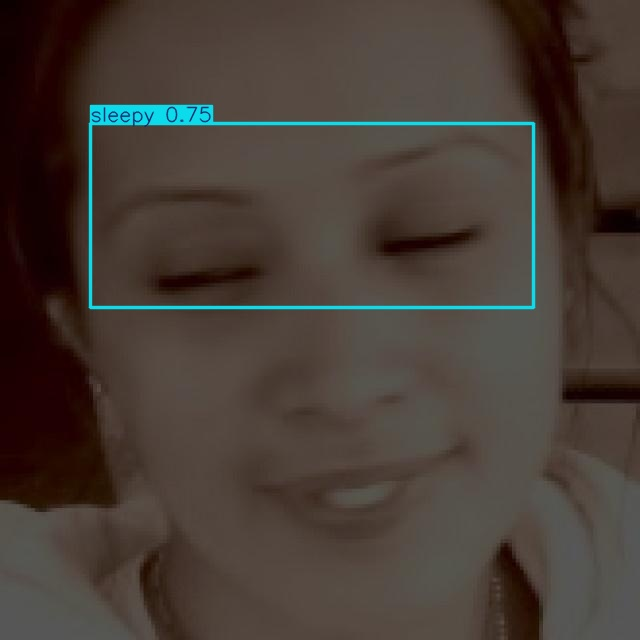

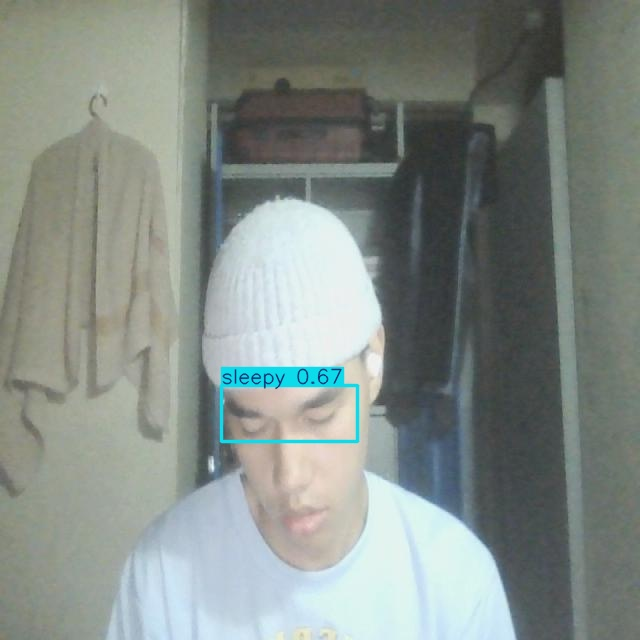

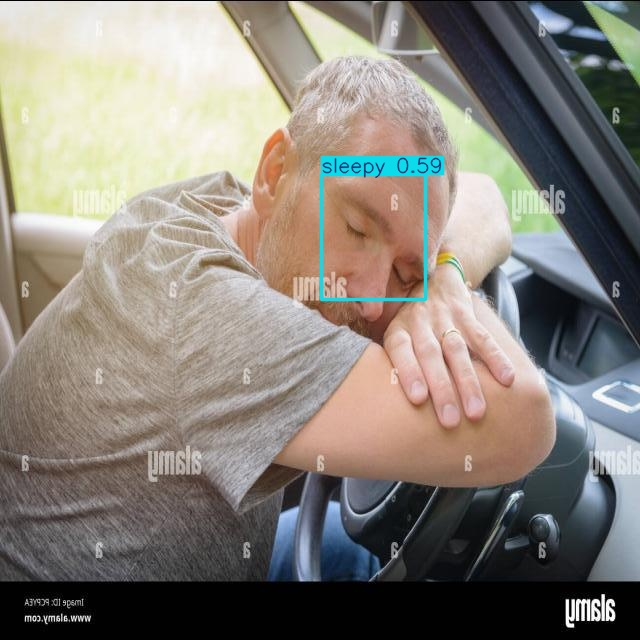

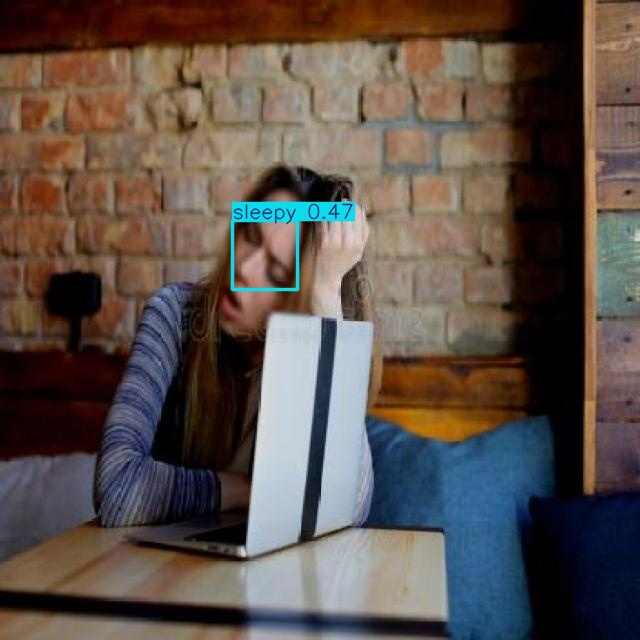

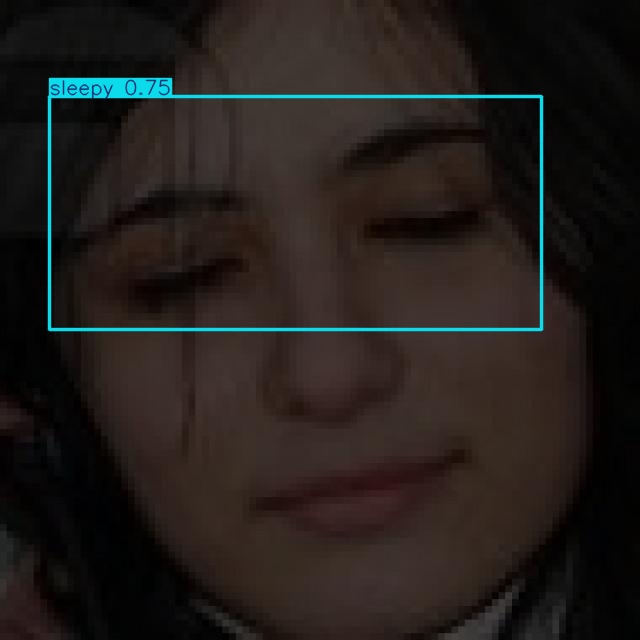

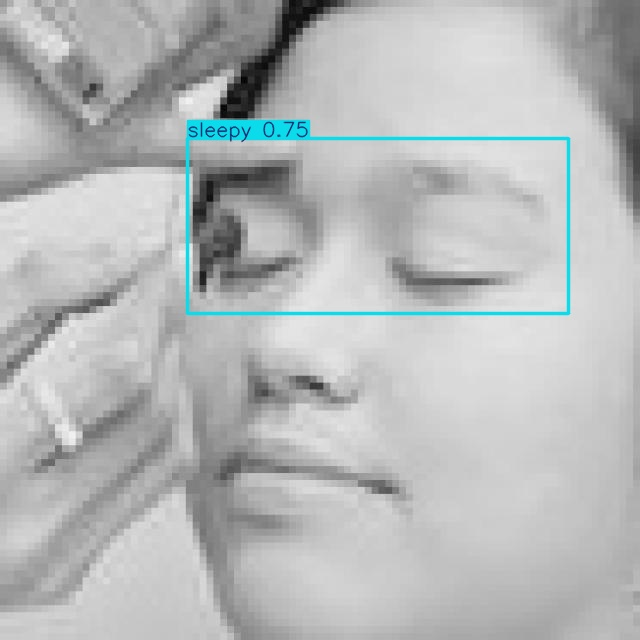

In [ ]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:50]:
  display(Image(filename=image_path, height=400))
  print('\n')


In [ ]:
# Create "my_model" folder to store model weights and train results
!mkdir -p /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

# Zip into "my_model.zip"
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train
%cd /content

/content/my_model
updating: my_model.pt (deflated 8%)
  adding: train/ (stored 0%)
  adding: train/confusion_matrix.png (deflated 34%)
  adding: train/val_batch2_labels.jpg (deflated 14%)
  adding: train/args.yaml (deflated 53%)
  adding: train/results.png (deflated 7%)
  adding: train/F1_curve.png (deflated 13%)
  adding: train/val_batch2_pred.jpg (deflated 14%)
  adding: train/val_batch0_pred.jpg (deflated 9%)
  adding: train/confusion_matrix_normalized.png (deflated 30%)
  adding: train/train_batch2.jpg (deflated 4%)
  adding: train/train_batch1982.jpg (deflated 12%)
  adding: train/val_batch1_labels.jpg (deflated 17%)
  adding: train/weights/ (stored 0%)
  adding: train/weights/best.pt (deflated 8%)
  adding: train/weights/last.pt (deflated 8%)
  adding: train/train_batch0.jpg (deflated 4%)
  adding: train/labels_correlogram.jpg (deflated 40%)
  adding: train/train_batch1980.jpg (deflated 12%)
  adding: train/R_curve.png (deflated 14%)
  adding: train/train_batch1981.jpg (deflated 

In [ ]:
!zip -r /content/my_model.zip /content/my_model


  adding: content/my_model/ (stored 0%)
  adding: content/my_model/train/ (stored 0%)
  adding: content/my_model/train/confusion_matrix.png (deflated 34%)
  adding: content/my_model/train/val_batch2_labels.jpg (deflated 14%)
  adding: content/my_model/train/args.yaml (deflated 53%)
  adding: content/my_model/train/results.png (deflated 7%)
  adding: content/my_model/train/F1_curve.png (deflated 13%)
  adding: content/my_model/train/val_batch2_pred.jpg (deflated 14%)
  adding: content/my_model/train/val_batch0_pred.jpg (deflated 9%)
  adding: content/my_model/train/confusion_matrix_normalized.png (deflated 30%)
  adding: content/my_model/train/train_batch2.jpg (deflated 4%)
  adding: content/my_model/train/train_batch1982.jpg (deflated 12%)
  adding: content/my_model/train/val_batch1_labels.jpg (deflated 17%)
  adding: content/my_model/train/weights/ (stored 0%)
  adding: content/my_model/train/weights/best.pt (deflated 8%)
  adding: content/my_model/train/weights/last.pt (deflated 8%)


In [ ]:
from google.colab import files
files.download('/content/my_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>